# Node Classification - MAG
## Experiment results

In [ ]:
import comet_ml
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch

sns.set_style('white')

In [ ]:
models = ['gcn', 'sage', 'gin']
types = ['base', 'transfer', 'self-transfer', 'self-transfer-new-layer']

***
### Gathering results
Run the cell below to gather all the experiment results from  Comet.ml.

In [ ]:
comet_api = comet_ml.api.API()
experiments = comet_api.get('graph-net-experiments/node-classification')

# gets dict with experiment_id : set of tags
experiments_with_tags = {
    exp.id: frozenset(exp.get_tags())
    for exp in experiments
}

tags = set(experiments_with_tags.values()) # gets unique tags
experiments_by_tags = { tag: [] for tag in tags } 

# experiments_by_tags: dict with all experiment ids under unique tags
for exp, exp_tags in experiments_with_tags.items():
    experiments_by_tags[exp_tags].append(exp)

experiment_results = { tag: '💩' for tag in tags }  # 💩 emoji will be replaced with exp. results

print('Gathering experiment results')
print('----------------------------')

for exp_model in models:
    print(exp_model + '...')

    for exp_type in types:
        print('    ' + exp_type)
        exp_tag = frozenset({exp_model, exp_type})

        losses = []
        accuracies = []

        for exp_id in experiments_by_tags[exp_tag]:
            loss = np.array([  float(step['metricValue'])
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('train_loss')])
            acc   = np.array([  float(step['metricValue']) 
                            for step in comet_api.get_experiment_by_id(exp_id).get_metrics('accuracy')])
            
            # insert nan at end when short of one value
            if len(loss) == 1999: 
                loss = np.hstack( (loss, np.nan) )
            if len(acc) == 1999: 
                acc = np.hstack( (acc, np.nan) )

            losses.append(loss)
            accuracies.append(acc)
            
        losses = np.stack(losses)
        accuracies = np.stack(accuracies)

        experiment_results[exp_tag] = {
            'losses': losses,
            'accuracies': accuracies
        }

Gathering experiment results
----------------------------
gcn...
    base
    transfer
    self-transfer
    self-transfer-new-layer
sage...
    base
    transfer
    self-transfer
    self-transfer-new-layer
gin...
    base
    transfer
    self-transfer
    self-transfer-new-layer


In [ ]:
torch.save(experiment_results, 'experiment_result_dict')

### Plotting results
Alternatively, use saved results from `experiment_result_dict`.

In [ ]:
experiment_results = torch.load('experiment_result_dict')

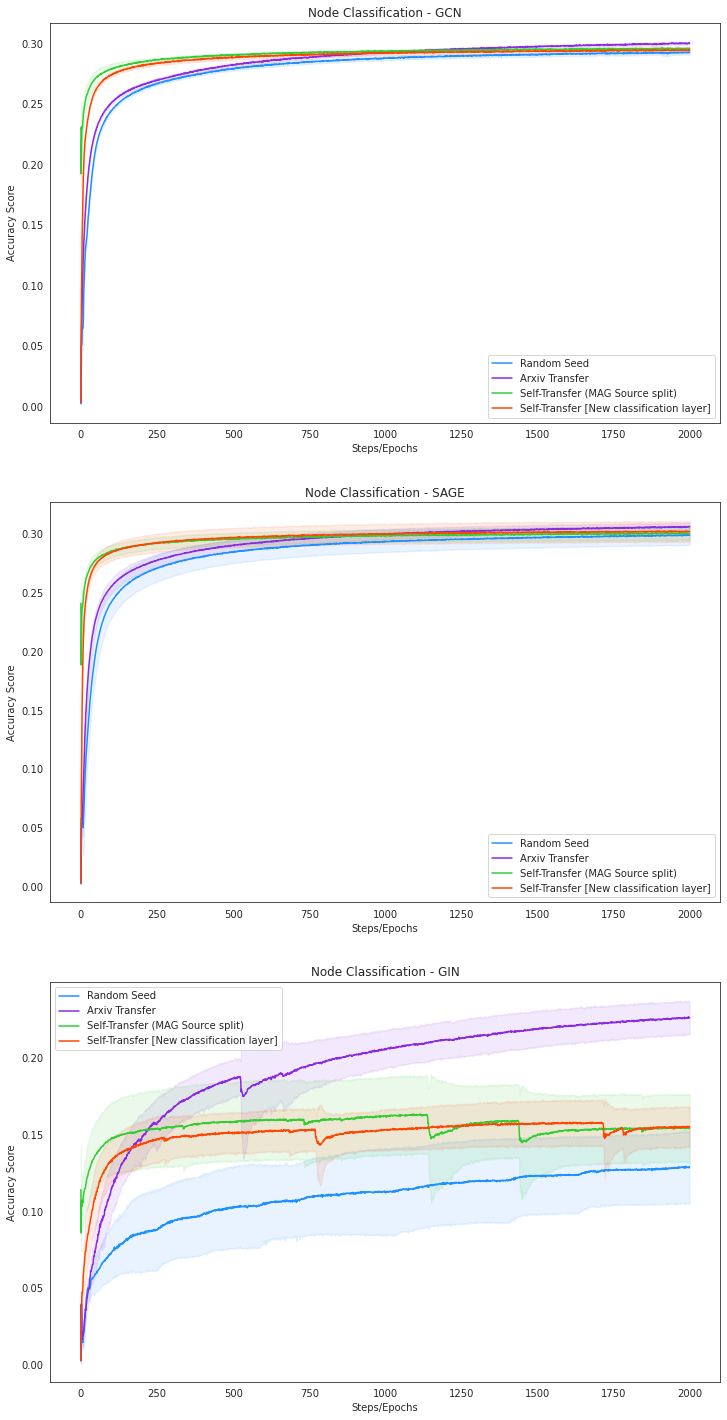

In [ ]:
legend_dict = {
    'base': 'Random Seed',
    'transfer': 'Arxiv Transfer',
    'self-transfer': 'Self-Transfer (MAG Source split)',
    'self-transfer-new-layer': 'Self-Transfer [New classification layer]'}
colours = {'base': 'dodgerblue', 'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered',}

plt.figure(figsize=(12, 25))

for i, model in enumerate(models):
    plt.subplot(3,1,i+1)

    for type_ in types:
        acc = experiment_results[frozenset({model, type_})]['accuracies']
        acc_mean = acc.mean(axis=0)
        acc_std = (acc_mean + acc.std(axis=0), acc_mean - acc.std(axis=0))

        plt.plot(acc.mean(axis=0), label=legend_dict[type_], color=colours[type_])
        plt.fill_between(np.arange(len(acc_mean)), acc_std[0], acc_std[1], alpha=0.1, color=colours[type_])
    
    plt.xlabel('Steps/Epochs')
    plt.ylabel('Accuracy Score')
    plt.title('Node Classification - ' + model.upper())
    plt.legend()

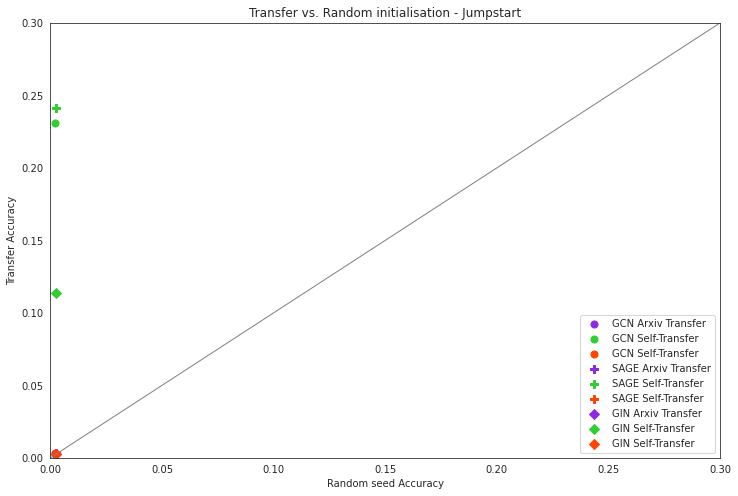

In [ ]:
colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'][:, 0].mean()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'][:, 0].mean()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'][:, 0].mean()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'][:, 0].mean()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='grey', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Jumpstart')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();

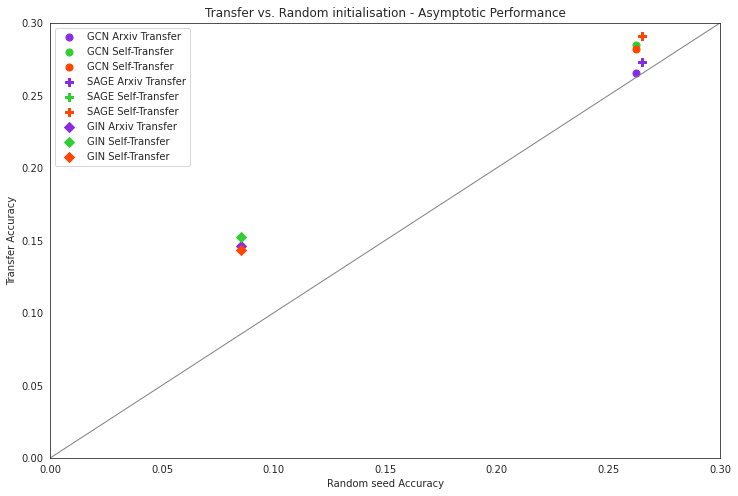

In [ ]:
colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'][:, 199].mean()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'][:, 199].mean()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'][:, 199].mean()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'][:, 199].mean()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='grey', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Asymptotic Performance')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();

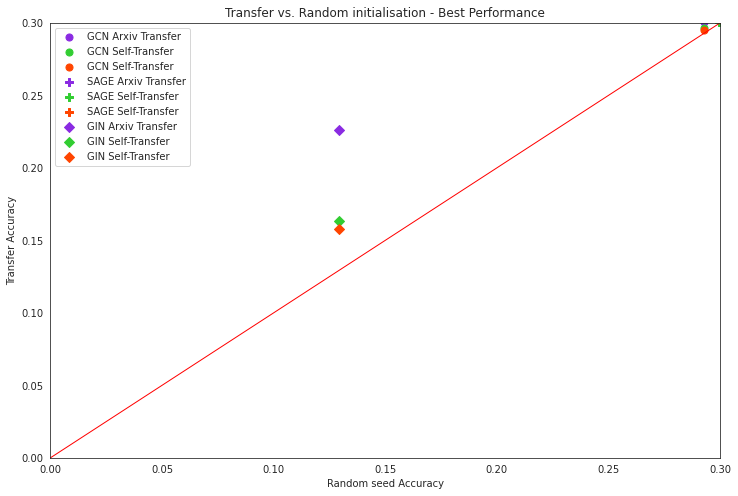

In [ ]:
colours = {'transfer': 'blueviolet', 'self-transfer': 'limegreen', 'self-transfer-new-layer': 'orangered'}
markers = {'gcn': 'o', 'sage': 'P', 'gin': 'D'}

plt.figure(figsize=(12,8))

for model in models:
    base = experiment_results[frozenset({model, 'base'})]['accuracies'].mean(axis=0).max()
    transfer = experiment_results[frozenset({model, 'transfer'})]['accuracies'].mean(axis=0).max()
    self_transfer = experiment_results[frozenset({model, 'self-transfer'})]['accuracies'].mean(axis=0).max()
    self_transfer_new_layer = experiment_results[frozenset({model, 'self-transfer-new-layer'})]['accuracies'].mean(axis=0).max()

    plt.scatter(base, transfer, marker=markers[model], s=50,
                label='{} Arxiv Transfer'.format(model.upper()), color=colours['transfer'])
    plt.scatter(base, self_transfer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer'])
    plt.scatter(base, self_transfer_new_layer, marker=markers[model], s=50,
                label='{} Self-Transfer'.format(model.upper()), color=colours['self-transfer-new-layer'])

plt.plot(np.linspace(0, 1), np.linspace(0, 1), color='red', lw=1)

axes = plt.gca()
axes.set_xlim([0, 0.3])
axes.set_ylim([0, 0.3])

plt.title('Transfer vs. Random initialisation - Best Performance')
plt.xlabel('Random seed Accuracy')
plt.ylabel('Transfer Accuracy')
plt.legend();